# Narzędzie do wizualizacji

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# QuadTree 

In [3]:
def create_first_scene(points, left, right, bottom, top):  
    lines = [[[left, top], [left, bottom]],
            [[left, bottom], [right, bottom]],
            [[right, bottom], [right, top]],
            [[right, top], [left, top]]]
    
    scenes = [(Scene([PointsCollection(points[:], color='cornflowerblue', marker = "o")],
                [LinesCollection(lines[:], color='cornflowerblue')]))]
    
    return scenes, lines


def add_scene(scenes, points, lines, top, left, bottom, right):
    lines.append([[left, (top + bottom) / 2], [right, (top + bottom) / 2]])
    lines.append([[(left + right) / 2, top], [(left + right) / 2, bottom]])
    scenes.append(Scene([PointsCollection(points[:], color='cornflowerblue', marker = "o")],
                [LinesCollection(lines[:], color='cornflowerblue')]))

    
def create_first_scene_2(points, lines, top_boundary, left_boundary, bottom_boundary, right_boundary):
    boundaries = [[[left_boundary, top_boundary], [left_boundary, bottom_boundary]],
            [[left_boundary, bottom_boundary], [right_boundary, bottom_boundary]],
            [[right_boundary, bottom_boundary], [right_boundary, top_boundary]],
            [[right_boundary, top_boundary], [left_boundary, top_boundary]]]
    
    scenes_2 = [(Scene([PointsCollection(points[:], color='cornflowerblue', marker = "o")],
                [LinesCollection(lines[:], color='cornflowerblue'),
                LinesCollection(boundaries[:], color='black')]))]
    
    return scenes_2, boundaries
    
    
def add_scene_2(scenes, points, lines, top, left, bottom, right, points_inside, boundaries):
    
    searching_lines =[[[left, top], [left, bottom]], [[left, bottom], [right, bottom]],
                      [[right, bottom], [right, top]], [[right, top], [left, top]]]
    
    scenes.append(Scene([PointsCollection(points[:], color='cornflowerblue', marker = "o"), 
                        PointsCollection(points_inside[:], color='red', marker = "o")],
                [LinesCollection(lines[:], color='cornflowerblue'),
                LinesCollection(searching_lines[:], color='red'),
                LinesCollection(boundaries[:], color='black')]))
    
       
def add_scene_2_leaf(scenes, points, lines, top, left, bottom, right, points_inside, leaf_index, boundaries):
    split_vertical = (top + bottom) / 2
    split_horizontal = (left + right) / 2
    
    if leaf_index == 0:
        left = split_horizontal
        bottom = split_vertical
    if leaf_index == 1:
        bottom = split_vertical
        right = split_horizontal
    if leaf_index == 2:
        right = split_horizontal
        top = split_vertical
    if leaf_index == 3:
        top = split_vertical
        left = split_horizontal
        
    searching_lines =[[[left, top], [left, bottom]], [[left, bottom], [right, bottom]],
                      [[right, bottom], [right, top]], [[right, top], [left, top]]]
    
    scenes.append(Scene([PointsCollection(points[:], color='cornflowerblue', marker = "o"), 
                        PointsCollection(points_inside[:], color='red', marker = "o")],
                [LinesCollection(lines[:], color='cornflowerblue'),
                LinesCollection(searching_lines[:], color='red'),
                LinesCollection(boundaries[:], color='black')]))

In [4]:
import math
northeast = top = x = 0
northwest = left = y = 1
southwest = bottom = 2
southeast = right = 3

        
class Node:
    def __init__(self, top_boundary, left_boundary, bottom_boundary, right_boundary):
        self.boundaries = (top_boundary, left_boundary, bottom_boundary, right_boundary)
        self.children = [None, None, None, None]
        self.is_children_leaf = [False, False, False, False]
        
        
class Root:
    def __init__(self, no_points, is_leaf, leaf_point, node):
        self.no_points = no_points
        self.is_leaf = is_leaf
        self.leaf_point = leaf_point
        self.node = node

        
def found_boundaries(points):
    min_horizontal = math.inf
    max_horizontal = -math.inf
    min_vertical = math.inf
    max_vertical = -math.inf

    for point in points:
        min_horizontal = min(min_horizontal, point[x])
        max_horizontal = max(max_horizontal, point[x])
        min_vertical = min(min_vertical, point[y])
        max_vertical = max(max_vertical, point[y])

    return min_horizontal, max_horizontal, min_vertical, max_vertical


def prepare_next_nodes(parent, points, scenes, lines, points_to_draw):
    split_vertical = (parent.boundaries[top] + parent.boundaries[bottom]) / 2
    split_horizontal = (parent.boundaries[left] + parent.boundaries[right]) / 2

    children_points = [[], [], [], []]

    for point in points:
        if point[x] <= split_horizontal:
            if point[y] <= split_vertical:
                children_points[southwest].append(point)
            else:
                children_points[northwest].append(point)
        else:
            if point[y] <= split_vertical:
                children_points[southeast].append(point)
            else:
                children_points[northeast].append(point)

    for child_index in range(4):
        if len(children_points[child_index]) == 1:
            parent.children[child_index] = children_points[child_index][0]
            parent.is_children_leaf[child_index] = True

        elif len(children_points[child_index]) > 1:
            
            if child_index == northeast:
                add_scene(scenes, points_to_draw, lines, parent.boundaries[top], split_horizontal, split_vertical, parent.boundaries[right])
                new_children = Node(parent.boundaries[top], split_horizontal, split_vertical, parent.boundaries[right])
            if child_index == northwest:
                add_scene(scenes, points_to_draw, lines, parent.boundaries[top], parent.boundaries[left], split_vertical, split_horizontal)
                new_children = Node(parent.boundaries[top], parent.boundaries[left], split_vertical, split_horizontal)
            if child_index == southwest:
                add_scene(scenes, points_to_draw, lines, split_vertical, parent.boundaries[left], parent.boundaries[bottom], split_horizontal)
                new_children = Node(split_vertical, parent.boundaries[left], parent.boundaries[bottom], split_horizontal)
            if child_index == southeast:
                add_scene(scenes, points_to_draw, lines, split_vertical, split_horizontal, parent.boundaries[bottom], parent.boundaries[right])
                new_children = Node(split_vertical, split_horizontal, parent.boundaries[bottom], parent.boundaries[right])
                
            parent.children[child_index] = new_children
            prepare_next_nodes(new_children, children_points[child_index], scenes, lines, points_to_draw)

            
def create_root(points):
    left_boundary, right_boundary, bottom_boundary, top_boundary = found_boundaries(points)
    scenes, lines = create_first_scene(points, left_boundary, right_boundary, bottom_boundary, top_boundary)
    
    if len(points) == 0:
        return Root(True, False, None, None), scenes, lines
    if len(points) == 1:
        return Root(False, True, points[0], None), scenes, lines
    
    add_scene(scenes, points, lines, top_boundary, left_boundary, bottom_boundary, right_boundary)
    return Root(False, False, None, Node(top_boundary, left_boundary, bottom_boundary, right_boundary)), scenes, lines


def field_inside(field, top_boundary, left_boundary, bottom_boundary, right_boundary):
    if field.boundaries[top] < bottom_boundary:
        return False
    if field.boundaries[bottom] > top_boundary:
        return False
    if field.boundaries[left] > right_boundary:
        return False
    if field.boundaries[right] < left_boundary:
        return False

    return True


def find_in_nodes(parent, top_boundary, left_boundary, bottom_boundary, right_boundary, scenes_2, lines, points_to_draw, found_points_to_draw, boundaries):
    points_inside = []
    for child_index in range(4):
        if parent.is_children_leaf[child_index]:
            child = parent.children[child_index]
            add_scene_2_leaf(scenes_2, points_to_draw, lines, parent.boundaries[top], parent.boundaries[left], parent.boundaries[bottom], parent.boundaries[right], found_points_to_draw, child_index, boundaries)
            if bottom_boundary <= child[y] <= top_boundary and left_boundary <= child[x] <= right_boundary:
                points_inside.append(child)
                found_points_to_draw.append(child)
                
        elif parent.children[child_index] != None:
            child = parent.children[child_index]
            if field_inside(child, top_boundary, left_boundary, bottom_boundary, right_boundary):
                add_scene_2(scenes_2, points_to_draw, lines, child.boundaries[top], child.boundaries[left], child.boundaries[bottom], child.boundaries[right], found_points_to_draw, boundaries)
                points_inside += find_in_nodes(child, top_boundary, left_boundary, bottom_boundary, right_boundary, scenes_2, lines, points_to_draw, found_points_to_draw, boundaries)
                
    return points_inside


def find_points(root, top_boundary, left_boundary, bottom_boundary, right_boundary, scenes, lines, points):
    scenes_2, boundaries = create_first_scene_2(points, lines, top_boundary, left_boundary, bottom_boundary, right_boundary)
    if root.no_points == True:
        return [], scenes_2
    if root.is_leaf == True:
        if bottom_boundary <= root.leaf_point[y] <= top_boundary and left_boundary <= root.leaf_point[x] <= right_boundary:
            return [root.leaf_point], scenes_2 #todo
        else:
            return [], scenes_2 #todo
        
    points_inside = []
    return find_in_nodes(root.node, top_boundary, left_boundary, bottom_boundary, right_boundary, scenes_2, lines, points, [], boundaries), scenes_2

    
def prepare_tree(points):
    root, scenes, lines = create_root(points)
    
    if root.no_points == False and root.is_leaf == False:
        prepare_next_nodes(root.node, points, scenes, lines, points)
    
    return root, scenes, lines

# Wizualizacja działania QuadTree

In [5]:
points = [(5.3, 5.2), (5.3, 6.7), (6.0, 8.4), (6.3, 8.9), (7.3, 8.4000001), (8.85, 8.83), (8.82767, 7.8), (8.82767, 5.9), (8.82767, 5.59), (9.82767, 5.588), (7, 7), (7.2, 7.4), (8, 6.5), (7.499999, 5.49999), (6, 4), (6.2, 3.6), (8.9, 3.9), (0.44213512, 4.62532), (0.44213512, 4.626), (6.9, 7.8), (0.14144, 3.51), (1.2, 1.251)]
top_boundary = 8
left_boundary = 6
bottom_boundary = 4
right_boundary = 8.82767


tree, scenes, lines = prepare_tree(points)
solution_points, scenes_2 = find_points(tree, top_boundary, left_boundary, bottom_boundary, right_boundary, scenes, lines, points)

scenes += scenes_2
%matplotlib notebook
plot = Plot(scenes = scenes)
plot.draw()

solution_points

<IPython.core.display.Javascript object>

[(8.82767, 7.8),
 (6.9, 7.8),
 (7.2, 7.4),
 (7, 7),
 (8, 6.5),
 (7.499999, 5.49999),
 (8.82767, 5.9),
 (8.82767, 5.59),
 (6, 4)]

# KD-tree

In [19]:
class Visualizer:
    def __init__(self, points):
        self.scenes = []
        self.points = points
        self.lines = []
        l = self.lines[:]
        self.scenes.append(Scene([PointsCollection(self.points, color='cornflowerblue')], [LinesCollection(l, color='black')]))
        self.rectangle = []
        self.found_points = []
        self.region = []

    def add_line(self, p1, p2):
        line = [p1, p2]
        self.lines.append(line)
        l = self.lines[:]
        scene = Scene([PointsCollection(self.points, color='cornflowerblue')], [LinesCollection(l, color='cornflowerblue')])
        self.scenes.append(scene)

    def add_point(self, p1):
        self.found_points.append(p1)
        p = self.found_points[:]
        self.scenes.append(Scene([PointsCollection(self.points, color='cornflowerblue'), PointsCollection(p, color='red')],
                                 [LinesCollection(self.lines, color='cornflowerblue'),
                                  LinesCollection(self.rectangle, color='black'),
                                  LinesCollection(self.region, color='red')]))

    def add_rectangle(self, region):
        self.rectangle.append([(region[0][0], region[0][1]), (region[0][0], region[1][1])])
        self.rectangle.append([(region[0][0], region[0][1]), (region[1][0], region[0][1])])
        self.rectangle.append([(region[1][0], region[1][1]), (region[0][0], region[1][1])])
        self.rectangle.append([(region[1][0], region[1][1]), (region[1][0], region[0][1])])
        self.scenes.append(Scene([PointsCollection(self.points, color='cornflowerblue')],
                                 [LinesCollection(self.lines, color='cornflowerblue'),
                                  LinesCollection(self.rectangle, color='black')]))

    def add_region(self, lower_left, upper_right):

        region_lines = [[lower_left, (lower_left[0], upper_right[1])],
                        [lower_left, (upper_right[0], lower_left[1])], [upper_right, (lower_left[0], upper_right[1])],
                        [upper_right, (upper_right[0], lower_left[1])]]

        self.region = region_lines
        p = self.found_points[:]
        self.scenes.append(Scene([PointsCollection(self.points, color='cornflowerblue'),
                                  PointsCollection(p, color='red')],
                                 [LinesCollection(self.lines, color='cornflowerblue'),
                                  LinesCollection(self.rectangle, color='black'),
                                  LinesCollection(self.region, color='red')]))

    def add_last_scene(self):
        p = self.found_points[:]
        self.scenes.append(Scene([PointsCollection(self.points, color='cornflowerblue'),
                                  PointsCollection(p, color='red')],
                                 [LinesCollection(self.lines, color='cornflowerblue'),
                                  LinesCollection(self.rectangle, color='black')]))

In [16]:
from sys import maxsize

class Node:
    def __init__(self, point):
        self.point = point
        self.left = None
        self.right = None
        self.upper_right = None
        self.lower_left = None


def partition(arr,left,right, idx):
    pi=arr[right][idx]
    i=left-1

    for j in range(left,right):
        if arr[j][idx]<pi:
            i+=1
            arr[i],arr[j]=arr[j],arr[i]
    arr[i+1],arr[right]=arr[right],arr[i+1]

    return i+1


def kthStatistics(arr,left,right,k, idx):
    i=partition(arr,left,right, idx)
    if i==k:
        return
    if i>k:
        kthStatistics(arr,left,i-1,k, idx)
    else:
        kthStatistics(arr,i+1,right,k, idx)

# idx wskazuje po którym elemencie chcemy porównywać
def median_idx(idx, points):
    n = len(points)
    kthStatistics(points,0, n-1, n//2, idx)
    return n//2


def find_max(points):

    max_x = -maxsize
    max_y = -maxsize

    for x,y in points:
        if x > max_x:
            max_x = x
        if y > max_y:
            max_y = y

    return (max_x,max_y)

def find_min(points):
    min_x = maxsize
    min_y = maxsize

    for x, y in points:
        if x < min_x:
            min_x = x
        if y < min_y:
            min_y = y

    return (min_x, min_y)


class KDTree:
    def __init__(self,points, visualizer):
        self.root = self.construct(points, 0)
        self.visualizer = visualizer
        self.root.upper_right = find_max(points)
        self.root.lower_left = find_min(points)
        self.calculate_regions(self.root, 0)
        self.result =[]

    def construct(self, points, depth):
        n = len(points)

        if n<1:
            return None

        if n==1:
            return Node(points[0])

        idx = depth%2

        m = median_idx(idx,points)


        left = points[0:m]
        right = points[m+1:n]

        root = Node(points[m])
        left_child = self.construct(left, depth+1)
        right_child = self.construct(right, depth+1)

        root.right = right_child
        root.left = left_child

        return root

    def calculate_regions(self, root, depth):


        if root.right == None and root.left == None:
            root.lower_left = None
            root.upper_right = None
            return

        if self.visualizer:
            if depth%2==0:
                self.visualizer.add_line((root.point[0],root.lower_left[1]), (root.point[0], root.upper_right[1]))
            else:
                self.visualizer.add_line((root.lower_left[0], root.point[1]), (root.upper_right[0], root.point[1]))

        if root.right:

            if (depth%2==0):
                root.right.upper_right = root.upper_right
                root.right.lower_left = (root.point[0], root.lower_left[1])

            else:
                root.right.upper_right = root.upper_right
                root.right.lower_left = (root.lower_left[0], root.point[1])

            self.calculate_regions(root.right, depth+1)

        if root.left:

            # sortowane po x
            if (depth%2==0):
                root.left.upper_right = (root.point[0], root.upper_right[1])
                root.left.lower_left = root.lower_left

            else:
                root.left.upper_right = (root.upper_right[0], root.point[1])
                root.left.lower_left = root.lower_left

            self.calculate_regions(root.left, depth+1)


    def report_subtree(self,  root):
        self.result.append(root.point)
        if self.visualizer:
            self.visualizer.add_point(root.point)

        if root.left:
            self.report_subtree(root.left)

        if root.right:
            self.report_subtree(root.right)

    def search(self, lower_left, upper_right):
        self.result = []
        if self.visualizer:
            self.visualizer.add_rectangle([lower_left, upper_right])

        self.search_kd_tree(self.root, lower_left, upper_right)
        return self.result

    def search_kd_tree(self, root, ll, ur):



        # aktualnie rozważany Node jest liściem
        if root.right == None and root.left == None:
            if point_inside(root.point, ll, ur):
                self.result.append(root.point)
                if self.visualizer:
                    self.visualizer.add_point(root.point)
            return

        if self.visualizer:
            self.visualizer.add_region(root.lower_left, root.upper_right)


        if point_inside(root.point, ll, ur):
            self.result.append(root.point)
            if self.visualizer:
                self.visualizer.add_point(root.point)

        if root.left:
            # rozważany prostokąt zawiera się w całości w obszarze obejmowanym przez root
            if region_inside(root.lower_left, root.upper_right, ll, ur):
                # wszystkie punkty z lewego poddrzewa znajdują sie w prostokącie
                self.report_subtree(root.left)

            # rozważany prostokąt przecina się z obszarem obejmowanym przez root
            elif region_intersects(root.lower_left, root.upper_right, ll, ur):
                self.search_kd_tree(root.left, ll, ur)

        if root.right:
            # rozważany prostokąt zawiera się w całości w obszarze obejmowanym przez root
            if region_inside(root.lower_left, root.upper_right, ll, ur):
                # wszystkie punkty z prawego poddrzewa znajdują sie w prostokącie
                self.report_subtree(root.right)

            # rozważany prostokąt przecina się z obszarem obejmowanym przez root
            elif region_intersects(root.lower_left, root.upper_right, ll, ur):
                self.search_kd_tree(root.right, ll, ur)


def point_inside(point, ll, ur):
    return point[0]>=ll[0] and point[0]<=ur[0] and point[1]>=ll[1] and point[1]<=ur[1]


def region_inside(region_ll, region_ur, ll, ur):
    return point_inside(region_ll, ll, ur) and point_inside(region_ur, ll, ur)

def region_intersects(region_ll, region_ur, ll, ur):
    return (point_inside(region_ll, ll, ur)
            or point_inside(region_ur, ll, ur)
            or point_inside(ll, region_ll, region_ur)
            or point_inside(ur, region_ll, region_ur)
            or point_inside((region_ll[0], region_ur[1]), ll, ur)
            or point_inside((ll[0], ur[1]), region_ll, region_ur))


In [9]:
from random import random

def random_points(lower_left, upper_right, n):

    points = [None]*n
    points_set = set()
    i =0
    while i < n:
        x = random()*upper_right[0]
        y = random()*upper_right[1]
        if (x,y) not in points_set:
            points_set.add((x,y))
            points[i] = (x,y)
            i+=1

    return points


# Wizualizacja tworzenia KD-tree

In [20]:
p1 = random_points((0,0),(1000,1000),100)
r1 = [(0,0),(500,500)]
visualizer = Visualizer(p1)
tree = KDTree(p1, visualizer)

plot = Plot(visualizer.scenes)
plot.draw()



<IPython.core.display.Javascript object>

# Wizualizacja wyszukiwania punktów w KD-tree

<IPython.core.display.Javascript object>


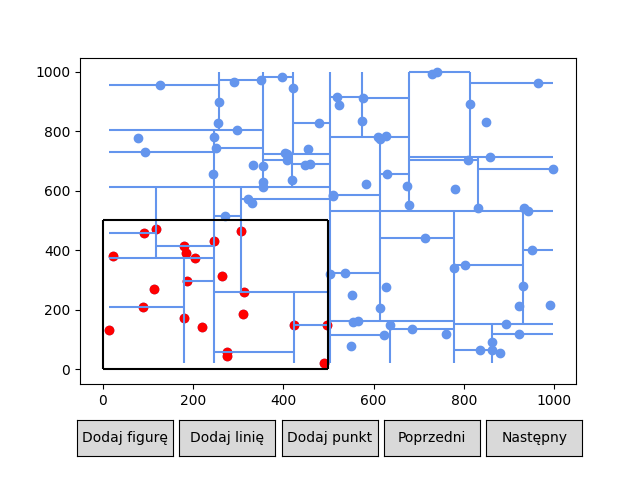

In [21]:
# dodaję ostatnią scenę z poprzedniej wizualizacji, żeby widzieć podział w drzewie
scene = visualizer.scenes[-1]
visualizer.scenes = []
visualizer.scenes.append(scene)

tree.search(r1[0], r1[1])
visualizer.add_last_scene() # dodaję ostatnią scenę uwzględniającą wszystkie znalezione punkty

plot = Plot(visualizer.scenes)
plot.draw()

